In [6]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

In [7]:
results_dir = "./simulation_results/"  # Path to directory with dump files
fe_atom_id = 1292                     # Atom ID of Fe (replace with your Fe ID)
o_atom_id = 3281                      # Atom ID of charged O (replace with your O ID)
output_file = "fe_o_distances.csv"  # Output file name for results

def parse_dump_file(file_path):
    """Parse LAMMPS dump file and return coordinates of target atoms."""
    fe_coords = None
    o_coords = None
    timestep = None

    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    # Find timestep and atom data
    for i, line in enumerate(lines):
        if "ITEM: TIMESTEP" in line:
            timestep = int(lines[i+1].strip())
        if "ITEM: ATOMS" in line:
            headers = line.split()[2:]  # Get column headers (id, type, x, y, z, etc.)
            data_start = i + 1
            break

    # Find indices of relevant columns
    id_idx = headers.index("id")
    x_idx = headers.index("x")
    y_idx = headers.index("y")
    z_idx = headers.index("z")

    # Parse atom data
    for line in lines[data_start:]:
        values = line.split()
        atom_id = int(values[id_idx])
        
        if atom_id == fe_atom_id:
            fe_coords = np.array([float(values[x_idx]), 
                                float(values[y_idx]), 
                                float(values[z_idx])])
        elif atom_id == o_atom_id:
            o_coords = np.array([float(values[x_idx]), 
                                float(values[y_idx]), 
                                float(values[z_idx])])
    
    return timestep, fe_coords, o_coords

In [8]:
dump_files = [f for f in os.listdir(results_dir) if f.startswith("dmp.") and f.endswith(".txt")]
dump_files.sort(key=lambda x: int(x.split('.')[1]))  # Sort by timestep

distances = []
for dump_file in dump_files:
    file_path = os.path.join(results_dir, dump_file)
    timestep, fe_coords, o_coords = parse_dump_file(file_path)
    
    if fe_coords is None or o_coords is None:
        print(f"Warning: Missing atoms in timestep {timestep}")
        continue
        
    distance = np.linalg.norm(o_coords - fe_coords)
    distances.append((timestep, distance))
    print(f"Timestep {timestep}: Distance = {distance:.3f} Å")

df = pd.DataFrame(distances, columns=["Timestep", "Distance (Å)"])
df.to_csv(output_file, index=False)

Timestep 0: Distance = 37.999 Å
Timestep 100: Distance = 36.829 Å
Timestep 200: Distance = 36.519 Å
Timestep 300: Distance = 36.402 Å
Timestep 400: Distance = 36.322 Å
Timestep 500: Distance = 36.257 Å
Timestep 600: Distance = 36.201 Å
Timestep 700: Distance = 36.154 Å
Timestep 800: Distance = 36.109 Å
Timestep 900: Distance = 36.068 Å
Timestep 1000: Distance = 36.025 Å
Timestep 1100: Distance = 36.011 Å
Timestep 1200: Distance = 35.995 Å
Timestep 1300: Distance = 35.978 Å
Timestep 1400: Distance = 35.959 Å
Timestep 1500: Distance = 35.939 Å
Timestep 1600: Distance = 35.918 Å
Timestep 1700: Distance = 35.895 Å
Timestep 1800: Distance = 35.872 Å
Timestep 1900: Distance = 35.847 Å
Timestep 2000: Distance = 35.822 Å
Timestep 2100: Distance = 35.795 Å
Timestep 2200: Distance = 35.767 Å
Timestep 2300: Distance = 35.737 Å
Timestep 2400: Distance = 35.705 Å
Timestep 2500: Distance = 35.672 Å
Timestep 2600: Distance = 35.636 Å
Timestep 2700: Distance = 35.599 Å
Timestep 2800: Distance = 35.560

In [9]:
distances = np.array(distances)

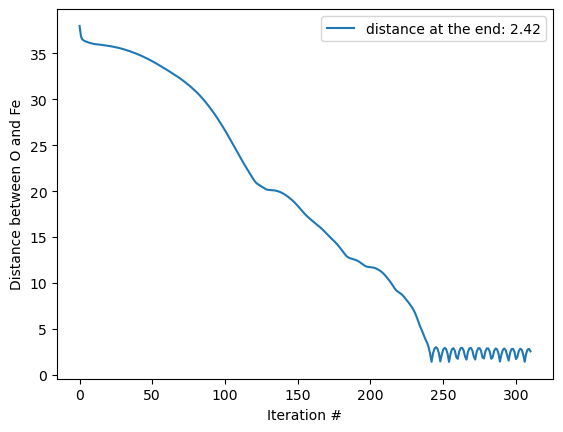

In [15]:
plt.plot(distances[:, 1], label=f"distance at the end: {np.mean(distances[-50:, 1]):.2f}")
plt.legend()
plt.ylabel('Distance between O and Fe')
plt.xlabel('Iteration #')
plt.show()